# Replicating results of Smith and Randall 2015
Purpose of this notebook is to replicate the results of "Rolling element bearing diagnostics using the Case Western
Reserve University data: A benchmark study"
http://dx.doi.org/10.1016/j.ymssp.2015.04.021

#### Imports and Configuration

In [2]:
# --- Standard Library ---
import os
import sys
from pathlib import Path
import glob

# --- Third-Party Libraries ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks

# --- Internal Project Modules ---
# Ensure the project root directory is in sys.path so imports work
project_root = Path().resolve().parent.parent  # Go up two levels from notebooks to project root
sys.path.append(str(project_root))
sys.path.append(str(project_root / "src"))  # Add src directory for openconmo imports

from openconmo.benchmark_methods import envelope, cepstrum_prewhitening, benchmark_method
import scripts.data_utils as du

# --- Plotting Configuration ---
%matplotlib inline

#### Utility functions


In [5]:
def setup_axis(ax, x_data, y_data, xlim=None, ylim=None, label=None):
    '''Plots data on the given axis with optional limits and title label'''
    ax.plot(x_data, y_data, c="b", linewidth=0.5)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if label:
        ax.set_title(label, loc="left")


def find_mat_file(record_number, base_dir="../data/CWRU-dataset"):
    ''' Recursively finds a .mat file matching the record number in base directory'''
    pattern = f"**/*{record_number}*.mat"
    full_pattern = os.path.join(base_dir, pattern)
    mat_files = glob.glob(full_pattern, recursive=True)

    if not mat_files:
        raise FileNotFoundError(f"No .mat file found for record {record_number} in {base_dir}")
    
    return mat_files[0]

#### Plotting functions

In [63]:
def plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, x1lim=None, y1lim=None, x2lim=None, y2lim=None):
    """Plot time-domain signal and its squared envelope spectrum side by side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

    setup_axis(ax1, time, signal, xlim=x1lim or (0, 5), ylim=y1lim or (-5, 5), label="a")
    setup_axis(ax2, sq_env_f, sq_env, xlim=x2lim or (0, 500), ylim=y2lim or (0, 5), label="b")
    ax1.set_xlabel("Time (s)")
    ax2.set_xlabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

def plot_env_spectrum(sq_env_f, sq_env, x1lim=None, y1lim=None):
    """Create a single plot showing the squared envelope spectrum."""
    fig, ax = plt.subplots(figsize=(3.5, 3))
    setup_axis(ax, sq_env_f, sq_env, xlim=x1lim or (0, 5), ylim=y1lim or (-5, 5))
    ax.set_xlabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

### Figure 5 — Record 209DE

**Sampling rate:** 12 kHz  
**Fault:** 0.021 in. drive end inner race fault  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Envelope spectrum from Method 1 (raw signal); Y1 diagnosis  
- (b) Envelope spectrum from Method 2 (prewhitening); Y2 diagnosis

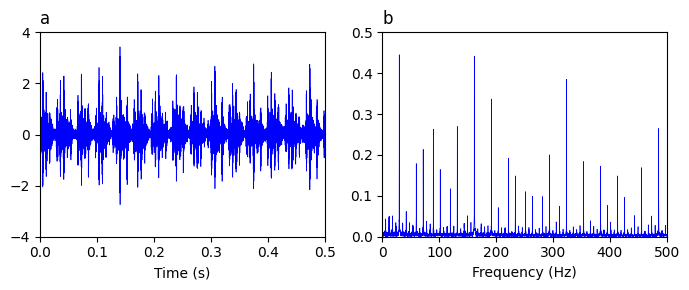

In [64]:
fs = 12e3
mat_files = find_mat_file(209)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0, 0.5), (-4, 4), (0, 500), (0, 0.5))


### Figure 6 — Record 169DE

**Sampling rate:** 12 kHz  
**Fault:** 0.014 in. drive end inner race fault  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis

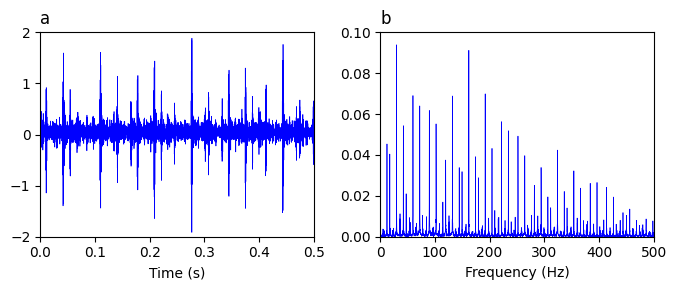

In [66]:
fs = 12e3
mat_files = find_mat_file(169)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0, 0.5), (-2, 2), (0, 500), (0, 0.1))

### Figure 7 — Record 3007DE

**Sampling rate:** 12 kHz  
**Fault:** 0.028 in. drive end ball fault  
**Speed:** 1750 RPM  
**Method(s):**  
- Envelope spectrum from Method 3 (benchmark); Y1 diagnosis

Computing the DRS: 100%|██████████| 112291/112291 [00:00<00:00, 277042.23it/s]

Max Level: 2.0
Freq: 0.0625
Fs: 12000.0
Max Kurtosis: 1.3668299947594975
Center frequency: 0.75
Bandwidth: 1500.0
Fs: 12000.0
Fc: 750.0
Nyquist: 6000.0
Lowcut: 1e-09
Highcut: 0.25
signal : [-0.27324029  4.17743636  0.65231351 ...  0.06914857  0.77759205
  0.32925704]


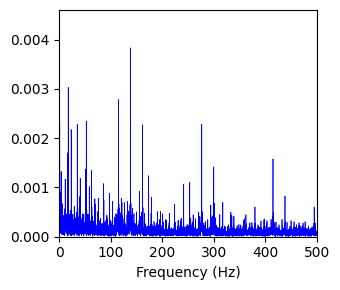

In [67]:
fs = 12e3
mat_files = find_mat_file(3007)

signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
t, s, sq_env_f, sq_env = benchmark_method(signal, fs, N=8192, Delta=500)

# Single-plot: envelope spectrum only
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.plot(sq_env_f, sq_env / 2, c="b", linewidth=0.5)
ax.set_xlim(0, 500)
ax.set_ylim(0, 4.6e-3)
ax.set_xlabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

### Figure 8 — Record 118DE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. drive end ball fault  
**Speed:** 1797 RPM  
**Method(s):**  
- Envelope spectrum from Method 1 (raw signal); N1 diagnosis

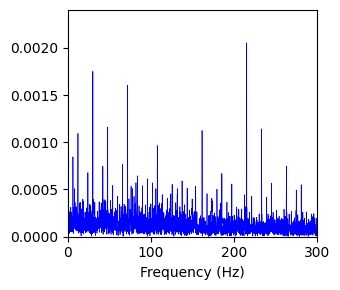

In [68]:
fs = 12e3
mat_files = find_mat_file(118)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
signal = signal / 2
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_env_spectrum(sq_env_f, sq_env, (0, 300), (0, 0.0024))

### Figure 10 — Record 222DE

**Sampling rate:** 12 kHz  
**Fault:** 0.021 in. drive end ball fault  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Raw time signal  
- (b) Envelope spectrum from Method 1 (raw signal); P1 diagnosis

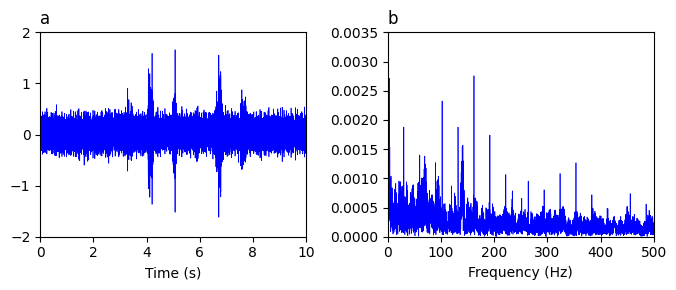

In [69]:
fs = 12e3
mat_files = find_mat_file(222)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env / 4, (0,10), (-2,2), (0, 500), (0, 0.0035))

### Figure 11 — Record 133DE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. drive end outer race fault (centred)  
**Speed:** 1730 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y1 diagnosis

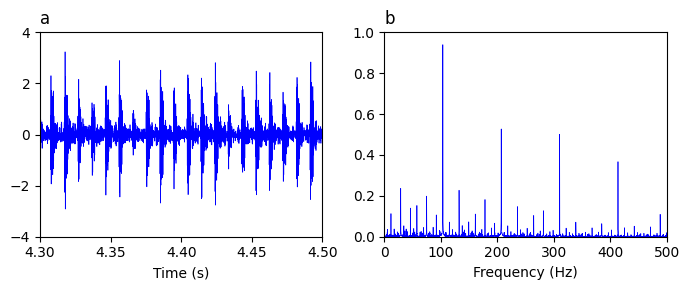

In [70]:
fs = 12e3
mat_files = find_mat_file(133)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (4.3, 4.5), (-4, 4), None, (0, 1))

### Figure 12 — Record 200DE

**Sampling rate:** 12 kHz  
**Fault:** 0.014 in. drive end outer race fault (centred)  
**Speed:** 1730 RPM  
**Method(s):**  
- (a) Time signal from Method 3 (benchmark)  
- (b) Corresponding envelope spectrum; N1 diagnosis

Computing the DRS: 100%|██████████| 113298/113298 [00:00<00:00, 272944.06it/s]


Max Level: 2.0
Freq: 0.3125
Fs: 12000.0
Max Kurtosis: 1.9829510782796764
Center frequency: 3.75
Bandwidth: 1500.0
Fs: 12000.0
Fc: 3750.0
Nyquist: 6000.0
Lowcut: 0.5
Highcut: 0.75
signal : [-0.01809801  0.1211676  -0.21059697 ...  0.02516565  0.12229474
 -0.02059122]


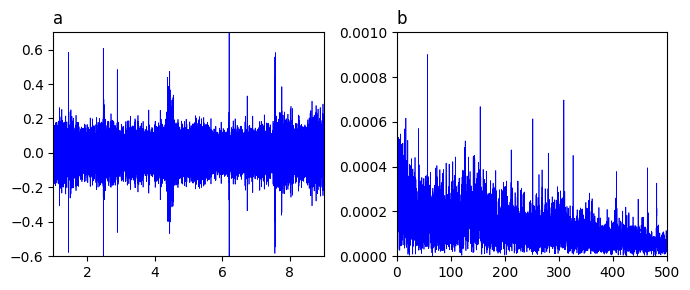

In [71]:
fs = 12e3
mat_files = find_mat_file(200)
title = "Fig. 12"

signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

t, s, sq_env_f, sq_env = benchmark_method(signal, fs, N=8192, Delta=500)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.plot(t, s, c="b", linewidth=0.5)  
ax2.plot(sq_env_f, sq_env/2, c="b", linewidth=0.5)

ax1.set_xlim(1, 9)
ax1.set_ylim(-0.6, 0.7)
ax2.set_xlim(0, 500)
ax2.set_ylim(0, 0.0010)

ax1.set_title("a", loc="left")
ax2.set_title("b", loc="left")
plt.tight_layout()
plt.show()

### Figure 14 — Record 235DE

**Sampling rate:** 12 kHz  
**Fault:** 0.021 in. drive end outer race fault (centred)  
**Speed:** 1772 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis

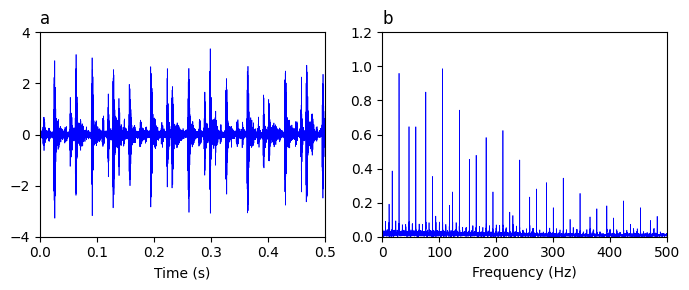

In [72]:
fs = 12e3
mat_files = find_mat_file(235)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0, 0.5), (-4, 4), None, (0, 1.2))

### Figure 15 — Record 144FE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. drive end outer race fault (orthogonal)  
**Speed:** 1797 RPM  
**Method(s):**  
- Envelope spectrum from Method 1 (raw signal); Y2 diagnosis

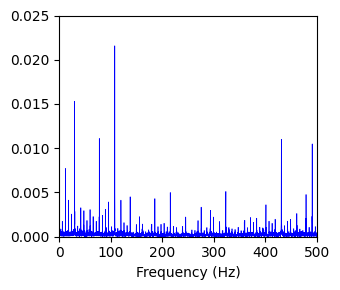

In [73]:
fs = 12e3
mat_files = find_mat_file(144)
_, signal, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_env_spectrum(sq_env_f, sq_env, (0, 500), (0, 0.025))

### Figure 16 — Record 146DE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. drive end outer race fault (orthogonal)  
**Speed:** 1750 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis

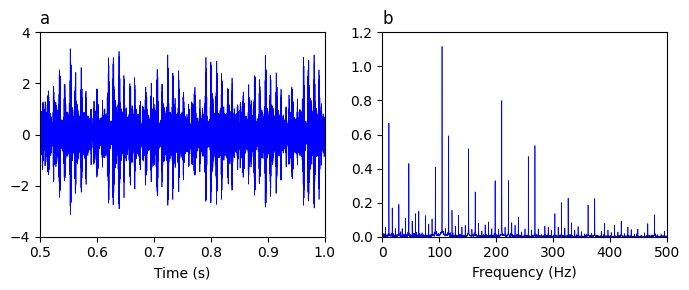

In [74]:
fs = 12e3
mat_files = find_mat_file(146)
title = "Fig. 16. Record 146DE – DE outer race fault (12k, 0.007 in, 1750 rpm)"
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0.5, 1), (-4, 4), None, (0, 1.2))

### Figure 17 — Record 246BA

**Sampling rate:** 12 kHz  
**Fault:** 0.021 in. drive end outer race fault (orthogonal)  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Raw time signal 
- (b) Envelope spectrum from Method 1 (raw signal); P1 diagnosis

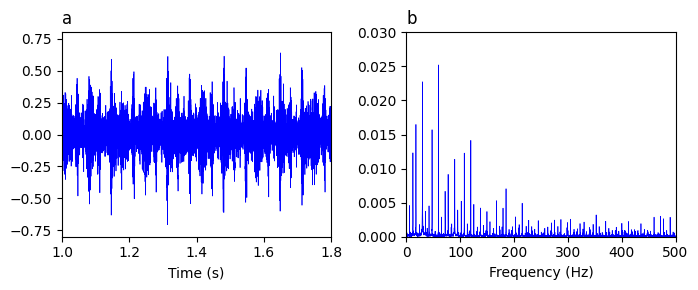

In [75]:
fs = 12e3
mat_files = find_mat_file(246)
_, _, signal, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (1, 1.8), (-0.8, 0.8), None, (0, 0.03))

### Figure 18 — Record 156DE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. drive end outer race fault (opposite)  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis


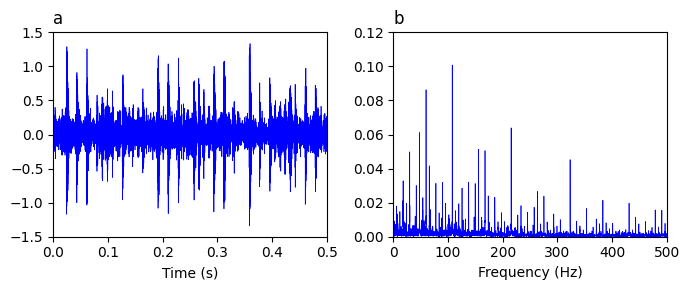

In [76]:
fs = 12e3
mat_files = find_mat_file(156)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0, 0.5), (-1.5, 1.5), None, (0, 0.12))

### Figure 19 — Record 156DE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. drive end outer race fault (opposite)  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Time signal from Method 2 (prewhitening)
- (b) Corresponding envelope spectrum; Y1 diagnosis


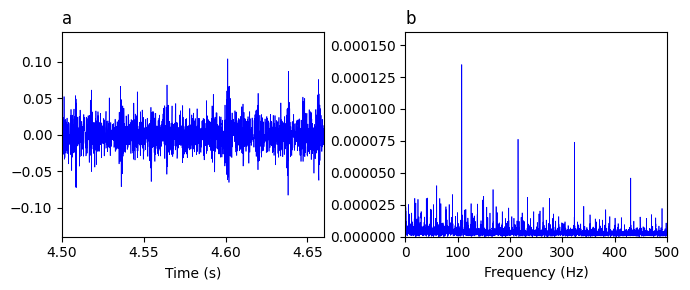

In [77]:
fs = 12e3
mat_files = find_mat_file(156)
title = "Fig. 19. Record 156DE – DE outer race fault (12k, 0.007 in, 1797 rpm)"

# Exctract DE signal
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

t,s = cepstrum_prewhitening(signal,fs)
s_mid = s[2000:-2000]

sq_env_f, sq_env = envelope(s_mid, fs)

plot_time_and_env_spectrum(t, s, sq_env_f, sq_env/2, (4.5, 4.66), (-0.14, 0.14), (0, 500), (0, 1.6e-4))

### Figure 20 — Record 109DE

**Sampling rate:** 48 kHz  
**Fault:** 0.007 in. drive end inner race fault  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis

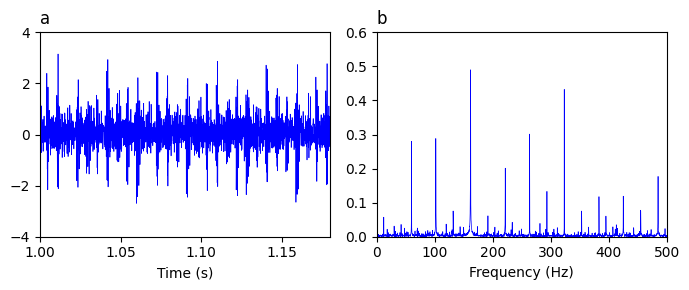

In [78]:
fs = 48e3
mat_files = find_mat_file(109)
title = "Fig. 20. Record 109DE – DE inner race fault (48k, 0.007 in, 1797 rpm)"
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (1, 1.18), (-4, 4), (0, 500), (0, 0.6));

### Figure 21 — Record 176DE

**Sampling rate:** 48 kHz  
**Fault:** 0.014 in. drive end inner race fault  
**Speed:** 1750 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); P1 diagnosis

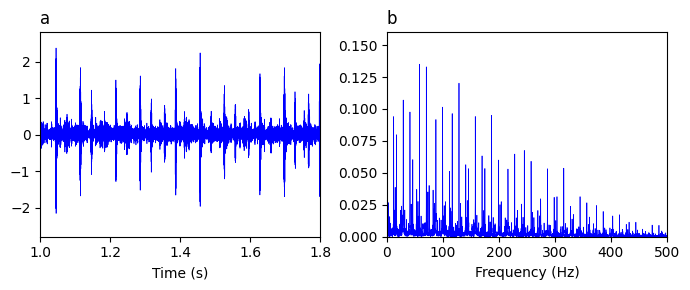

In [79]:
fs = 48e3
mat_files = find_mat_file(176)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (1, 1.8), (-2.8, 2.8), (0, 500), (0, 0.16));

### Figure 22 — Record 174DE

**Sampling rate:** 48 kHz  
**Fault:** 0.014 in. drive end inner race fault  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); N1 diagnosis

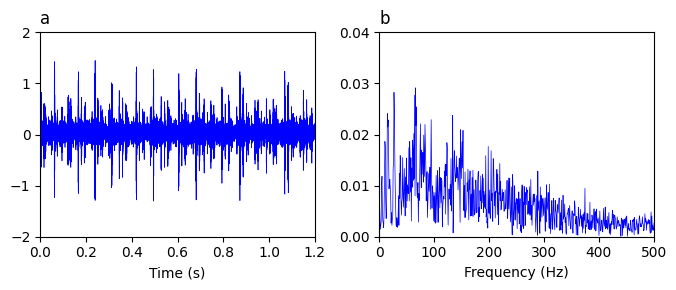

In [80]:
fs = 48e3
mat_files = find_mat_file(174)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0, 1.2), (-2,2), (0, 500), (0, 0.04))

### Figure 23 — Record 191DE

**Sampling rate:** 48 kHz  
**Fault:** 0.014 in. drive end ball fault  
**Speed:** 1750 RPM  
**Method(s):**  
- (a) Raw time signal  
- (b) Envelope spectrum from Method 1 (raw signal); N1 diagnosis

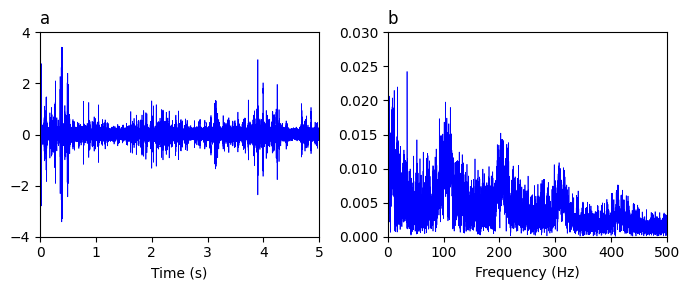

In [81]:
fs = 48e3
mat_files = find_mat_file(191)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0,5), (-4,4), (0, 500), (0, 0.03))

### Figure 24 — Record 227DE

**Sampling rate:** 48 kHz  
**Fault:** 0.021 in. drive end ball fault  
**Speed:** 1772 RPM  
**Method(s):**  
- (a) Raw time signal  
- (b) Envelope spectrum from Method 1 (raw signal); P1 diagnosis

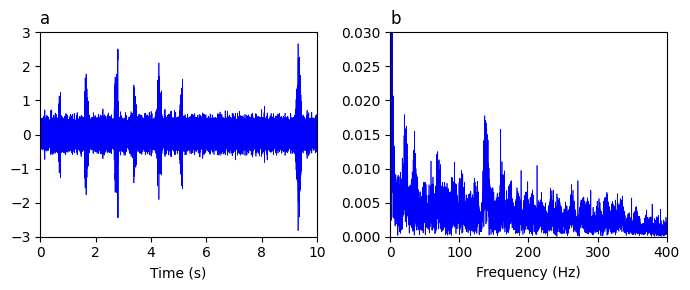

In [82]:
fs = 48e3
mat_files = find_mat_file(227)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0,10), (-3,3), (0, 400), (0, 0.03))

### Figure 25 — Record 226DE

**Sampling rate:** 48 kHz  
**Fault:** 0.021 in. drive end ball fault  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Envelope spectrum from Method 1 (raw signal); N1 diagnosis  
- (b) Envelope spectrum from Method 2 (prewhitening); P1 diagnosis

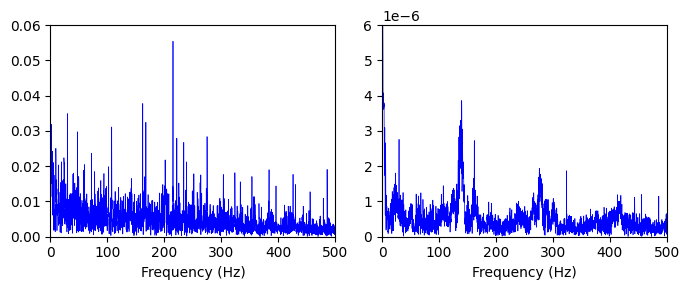

In [83]:
fs = 48e3
file_path = find_mat_file(226)

signal, _, _, rpm = du.extract_signals(file_path, normal=False)
sq_env_f, sq_env = envelope(signal, fs)

t, s = cepstrum_prewhitening(signal, fs)
s_mid = s[3000:-3000]  # Truncate edges to focus on central region
sq_env_f2, sq_env2 = envelope(s_mid, fs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
ax1.plot(sq_env_f, sq_env, c="b", linewidth=0.5)
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 0.06)

ax2.plot(sq_env_f2, sq_env2 / 2, c="b", linewidth=0.5)
ax2.set_xlim(0, 500)
ax2.set_ylim(0, 6e-6)

ax1.set_xlabel("Frequency (Hz)")
ax2.set_xlabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

### Figure 26 — Record 203DE

**Sampling rate:** 48 kHz  
**Fault:** 0.014 in. drive end outer race fault (centred)  
**Speed:** 1750 RPM  
**Method(s):**  
- (a) Raw time signal  
- (b) Envelope spectrum from Method 1 (raw signal); P2 diagnosis

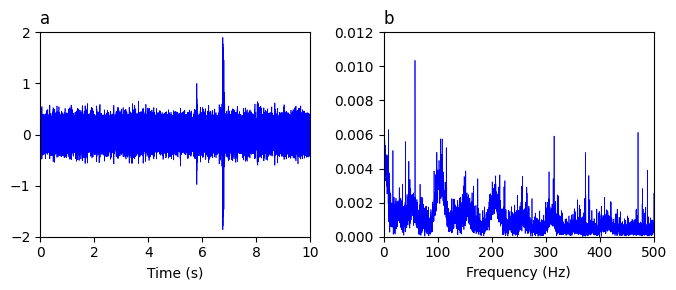

In [84]:
fs = 48e3
mat_files = find_mat_file(203)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0, 10), (-2, 2), None, (0, 0.012))

### Figure 27 — Record 239DE

**Sampling rate:** 48 kHz  
**Fault:** 0.021 in. drive end outer race fault (centred)  
**Speed:** 1772 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis

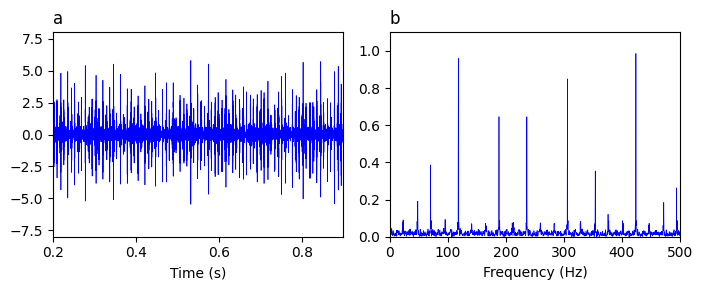

In [85]:
fs = 48e3
mat_files = find_mat_file(235)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0.2, 0.9), (-8, 8), None, (0, 1.1))

### Figure 28 — Record 148FE

**Sampling rate:** 48 kHz  
**Fault:** 0.007 in. drive end outer race fault (orthogonal)  
**Speed:** 1797 RPM  
**Method(s):**  
- Envelope spectrum from Method 1 (raw signal); Y1 diagnosis

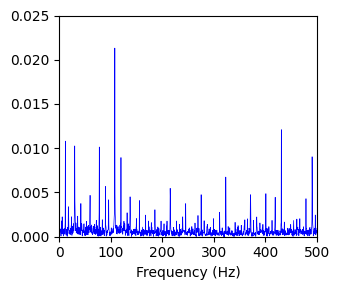

In [86]:
fs = 48e3
mat_files = find_mat_file(148)
_, signal, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_env_spectrum(sq_env_f, sq_env, (0, 500), (0, 0.025))

### Figure 29 — Records 161DE & 262DE

**Sampling rate:** 48 kHz  
**Fault:** Drive end outer race fault (opposite)  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Record 161DE: 0.007 in.; Envelope spectrum from Method 1 (raw signal); Y2 diagnosis  
- (b) Record 262DE: 0.021 in.; Envelope spectrum from Method 1 (raw signal); P1 diagnosis


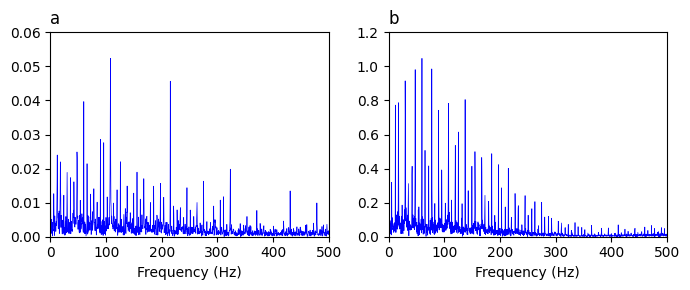

In [87]:
fs = 48e3
mat_files = find_mat_file(161)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))
sq_env_f, sq_env = envelope(signal, fs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.plot(sq_env_f, sq_env, c="b", linewidth=0.5)
ax1.set_xlim(0, 500)
ax1.set_ylim(0, 0.06)

mat_files = find_mat_file(262)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))
sq_env_f, sq_env = envelope(signal, fs)
ax2.plot(sq_env_f, sq_env, c="b", linewidth=0.5)

ax2.set_xlim(0, 500)
ax2.set_ylim(0, 1.2)

ax1.set_title("a", loc="left")
ax2.set_title("b", loc="left")
ax1.set_xlabel("Frequency (Hz)")
ax2.set_xlabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

### Figure 30 — Record 270FE

**Sampling rate:** 12 kHz  
**Fault:** 0.021 in. fan end inner race fault  
**Speed:** 1797 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis

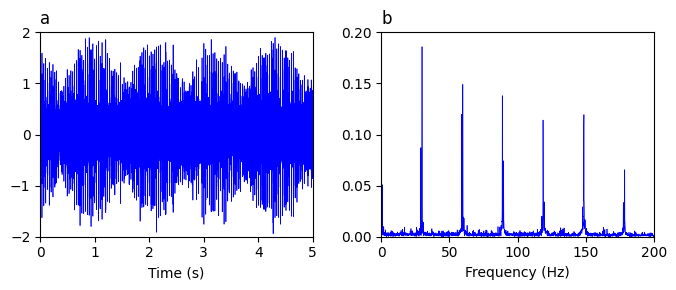

In [88]:
fs = 12e3
mat_files = find_mat_file(270)
title = "Fig. 30. Record 270FE – FE inner race fault (12k, 0.021 in, 1797 rpm)"
_, signal, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0,5), (-2,2), (0, 200), (0, 0.2))

### Figure 31 — Record 282

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. fan end ball fault  
**Speed:** 1797 RPM  
**Method(s):**  
- Envelope spectra from Method 1 (raw signal):  
  - (a) DE; P1 diagnosis  
  - (b) FE; N1 diagnosis  
  - (c) BA; Y2 diagnosis

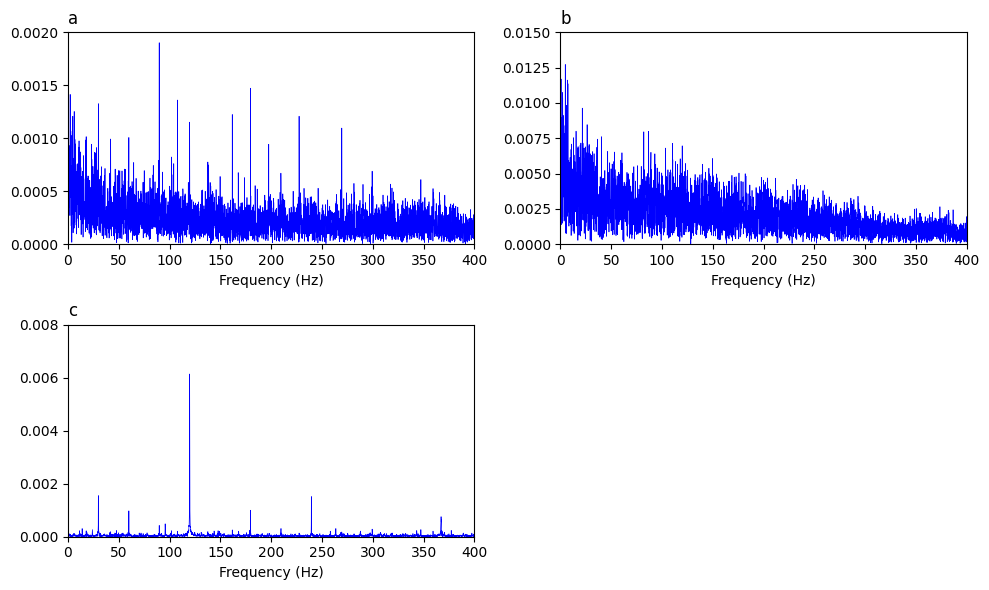

In [89]:
fs = 12e3
mat_files = find_mat_file(282)
signal1, signal2, signal3, rpm = du.extract_signals(mat_files, normal=False)
sq_env_f1, sq_env1 = envelope(signal1, fs)
sq_env_f2, sq_env2 = envelope(signal2, fs)
sq_env_f3, sq_env3 = envelope(signal3, fs)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Top-left plot
axes[0, 0].plot(sq_env_f1, sq_env1, c="b", linewidth=0.5)
axes[0, 0].set_xlim(0, 400)
axes[0, 0].set_ylim(0, 0.002)
axes[0, 0].set_title("a", loc="left")
axes[0, 0].set_xlabel("Frequency (Hz)")

# Top-right plot
axes[0, 1].plot(sq_env_f2, sq_env2, c="b", linewidth=0.5)
axes[0, 1].set_xlim(0, 400)
axes[0, 1].set_ylim(0, 0.015)
axes[0, 1].set_title("b", loc="left")
axes[0, 1].set_xlabel("Frequency (Hz)")

# Bottom-left plot
axes[1, 0].plot(sq_env_f3, sq_env3, c="b", linewidth=0.5)
axes[1, 0].set_xlim(0, 400)
axes[1, 0].set_ylim(0, 8e-3)
axes[1, 0].set_title("c", loc="left")
axes[1, 0].set_xlabel("Frequency (Hz)")

axes[1, 1].axis("off")  # Turn off the bottom-right subplot if not used

plt.tight_layout()
plt.show()

### Figure 32 — Record 283

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. fan end ball fault  
**Speed:** 1772 RPM  
**Method(s):**  
- Envelope spectra from Method 1 (raw signal):  
  - (a) DE; P2 diagnosis  
  - (b) FE; P2 diagnosis  
  - (c) BA; Y2 diagnosis

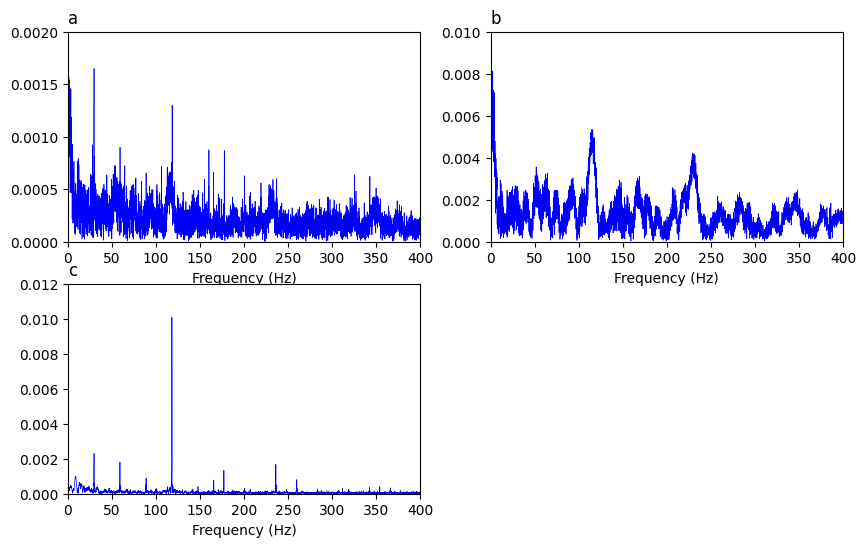

In [90]:
mat_files = find_mat_file(283)
signal1, signal2, signal3, rpm = du.extract_signals(mat_files, normal=False)
sq_env_f1, sq_env1 = envelope(signal1, fs)
sq_env_f2, sq_env2 = envelope(signal2, fs)
sq_env_f3, sq_env3 = envelope(signal3, fs)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Top-left plot
axes[0, 0].plot(sq_env_f1, sq_env1, c="b", linewidth=0.5)
axes[0, 0].set_xlim(0, 400)
axes[0, 0].set_ylim(0, 0.002)
axes[0, 0].set_title("a", loc="left")
axes[0, 0].set_xlabel("Frequency (Hz)")


# Top-right plot
axes[0, 1].plot(sq_env_f2, sq_env2, c="b", linewidth=0.5)
axes[0, 1].set_xlim(0, 400)
axes[0, 1].set_ylim(0, 0.01)
axes[0, 1].set_title("b", loc="left")
axes[0, 1].set_xlabel("Frequency (Hz)")

# Bottom-left plot
axes[1, 0].plot(sq_env_f3, sq_env3, c="b", linewidth=0.5)
axes[1, 0].set_xlim(0, 400)
axes[1, 0].set_ylim(0, 0.012)
axes[1, 0].set_title("c", loc="left")
axes[1, 0].set_xlabel("Frequency (Hz)")

# Leave the bottom-right plot empty
axes[1, 1].axis("off");  # Turn off the bottom-right subplot

### Figure 33 — Record 283

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. fan end ball fault  
**Speed:** 1772 RPM  
**Method(s):**  
- Raw time signals:  
  - (a) FE  
  - (b) BA

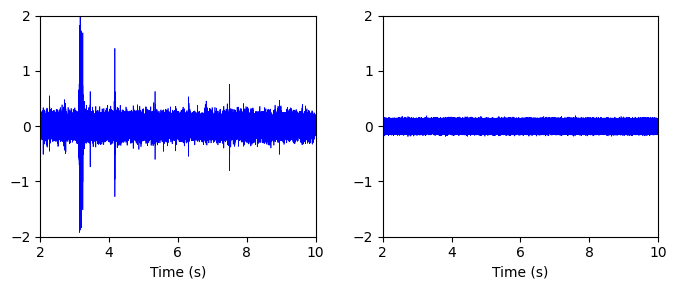

In [91]:
fs = 12e3
file_path = find_mat_file(283)

_, signal, _, rpm = du.extract_signals(file_path, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

# Left plot
ax1.plot(time, signal, c="b", linewidth=0.5)
ax1.set_xlim(2, 10)
ax1.set_ylim(-2, 2)

# Right plot
_, _, signal, rpm = du.extract_signals(file_path, normal=False)
ax2.plot(time, signal / 2, c="b", linewidth=0.5)
ax2.set_xlim(2, 10)
ax2.set_ylim(-2, 2)

ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

### Figure 34 — Record 295FE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. fan end outer race fault (centred)  
**Speed:** 1772 RPM  
**Method(s):**  
- Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis



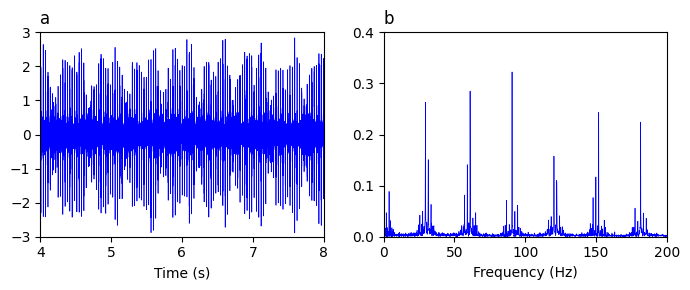

In [92]:
fs = 12e3
mat_files = find_mat_file(295)
_, signal, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (4, 8), (-3, 3), (0, 200), (0, 0.4))

### Figure 35 — Record 311

**Sampling rate:** 12 kHz  
**Fault:** 0.014 in. fan end outer race fault (orthogonal)  
**Speed:** 1750 RPM  
**Method(s):**  
- (a) Raw time signal
- (b) Envelope spectrum from Method 1 (raw signal); Y2 diagnosis  
- (c) Time signal from Method 2 (prewhitening)
- (d) Corresponding envelope spectrum; Y1 diagnosis

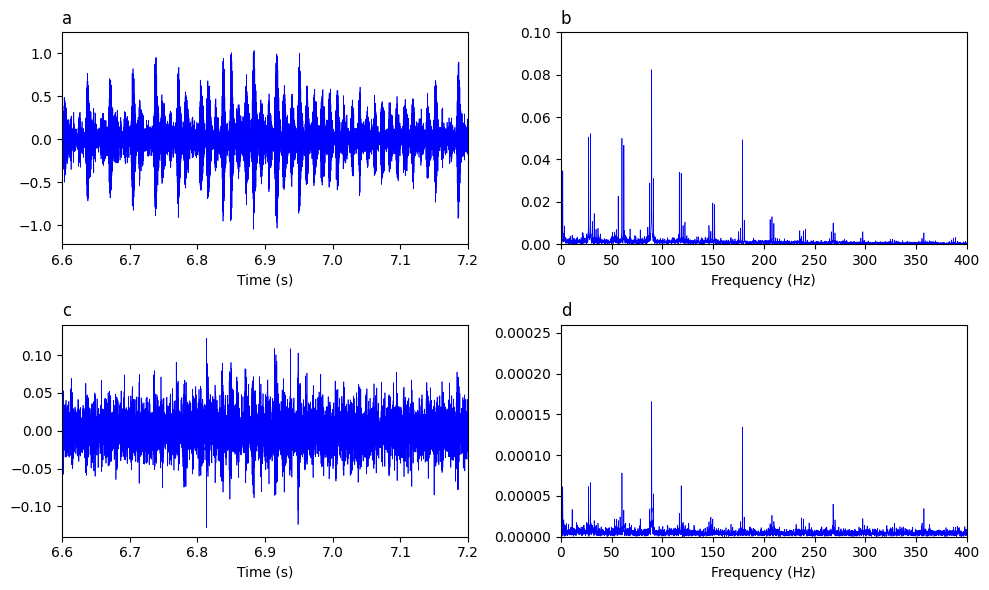

In [93]:
fs = 12e3
mat_files = find_mat_file(311)

signal, _, _, rpm = du.extract_signals(mat_files, normal=False)

sq_env_f, sq_env  = envelope(signal, fs)

time = np.linspace(0,len(signal)/fs,len(signal))
t,s = cepstrum_prewhitening(signal,fs)
s_mid = s[1008:-1008]
sq_env_f2, sq_env2 = envelope(s_mid, fs)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Top-left plot
axes[0, 0].plot(time, signal, c="b", linewidth=0.5)
axes[0, 0].set_xlim(6.6, 7.2)
#axes[0, 0].set_ylim(-0.14, 0.14)
axes[0, 0].set_title("a", loc="left")
axes[0, 0].set_xlabel("Time (s)")

# Top-right plot
axes[0, 1].plot(sq_env_f, sq_env, c="b", linewidth=0.5)
axes[0, 1].set_xlim(0, 400)
axes[0, 1].set_ylim(0, 0.1)
axes[0, 1].set_title("b", loc="left")
axes[0, 1].set_xlabel("Frequency (Hz)")

# Bottom-left plot
axes[1, 0].plot(t, s, c="b", linewidth=0.5)
axes[1, 0].set_xlim(6.6, 7.2)
axes[1, 0].set_ylim(-0.14, 0.14)
axes[1, 0].set_title("c", loc="left")
axes[1, 0].set_xlabel("Time (s)")

# Bottom-right plot
axes[1, 1].plot(sq_env_f2, sq_env2 / 2, c="b", linewidth=0.5)
axes[1, 1].set_xlim(0, 400)
axes[1, 1].set_ylim(0, 2.6e-4)
axes[1, 1].set_title("d", loc="left")
axes[1, 1].set_xlabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

### Figure 36 — Record 298DE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. fan end outer race fault (orthogonal)  
**Speed:** 1797 RPM  
**Method(s):**  
- Envelope spectrum from Method 1 (raw signal); N1 diagnosis

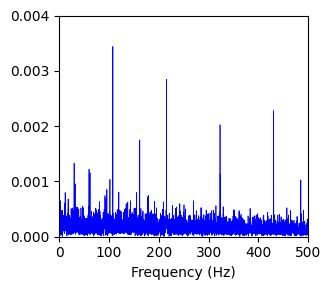

In [94]:
fs = 12e3
mat_files = find_mat_file(298)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_env_spectrum(sq_env_f, sq_env, (0, 500), (0, 4e-3))

### Figure 37 — Record 305DE

**Sampling rate:** 12 kHz  
**Fault:** 0.007 in. fan end outer race fault (opposite)  
**Speed:** 1772 RPM  
**Method(s):**  
- (a) Raw time signal  
- (b) Envelope spectrum from Method 1 (raw signal); P2 diagnosis

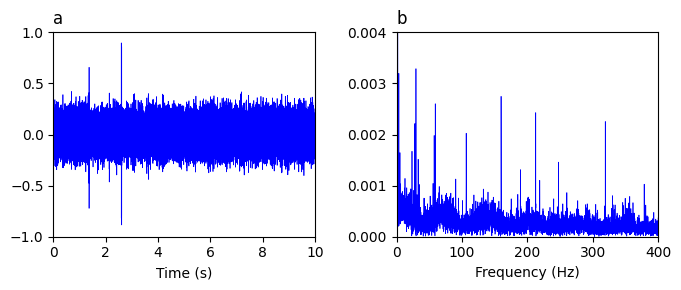

In [95]:
fs = 12e3
mat_files = find_mat_file(305)
signal, _, _, rpm = du.extract_signals(mat_files, normal=False)
time = np.linspace(0, len(signal)/fs, len(signal))

sq_env_f, sq_env = envelope(signal, fs)
plot_time_and_env_spectrum(time, signal, sq_env_f, sq_env, (0, 10), (-1, 1), (0, 400), (0, 0.004))